In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 7.2 MB/s 
     |████████████████████████████████| 212 kB 35.4 MB/s 
     |████████████████████████████████| 182 kB 64.3 MB/s 
     |████████████████████████████████| 132 kB 63.5 MB/s 
     |████████████████████████████████| 452 kB 79.3 MB/s 
     |████████████████████████████████| 127 kB 66.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
import random
import evaluate
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 0.001
random.seed(10)

##**Dataset**

In [ ]:
train_dataset =   torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_dataset =    torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

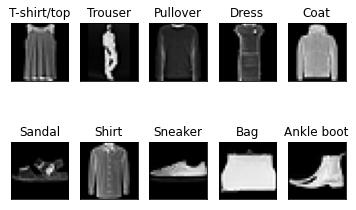

In [ ]:
fig = plt.figure()
for i in range(10):
  plt.subplot(2,5,i+1)
  class_indices = train_dataset.targets == i
  data_class = train_dataset.data[class_indices]
  selected_data = random.choice(data_class)
  plt.imshow(selected_data, cmap='gray')
  plt.title(class_names[i])
  plt.xticks([])
  plt.yticks([])
fig.show()

##**Model**

In [ ]:
class Linear:
  def __init__(self, in_size, out_size):
    self.in_size = in_size
    self.out_size = out_size
    self.w = torch.FloatTensor(self.out_size, self.in_size).uniform_(-1/28, 1/28)
    self.w.requires_grad = True
    self.b = torch.FloatTensor(self.out_size).uniform_(-1/28, 1/28)
    self.b.requires_grad = True
  
  def apply(self, input_data):
    return torch.matmul(input_data, self.w.t()) + self.b

class Activation:
  def __init__(self, function):
    self.function = function

  def apply_relu(self, input_data):
    return torch.maximum(input_data, torch.zeros_like(input_data))

  def apply_softmax(self, input_data):
    exp_tensor = torch.exp(input_data)
    tensor_sum = torch.sum(exp_tensor)
    return torch.div(exp_tensor, tensor_sum)

  def apply(self, input_data):
    if self.function == 'relu':
      return self.apply_relu(input_data)
    elif self.function == 'softmax':
      return self.apply_softmax(input_data)

class Layer:
  def __init__(self, linear, activation=None):
    self.linear = linear
    self.activation = activation

  def apply(self, input_data):
    linear_output = self.linear.apply(input_data)
    
    if self.activation:
      return self.activation.apply(linear_output)
    else:
      return linear_output

  def update(self):
    self.linear.w.data = self.linear.w.data - LEARNING_RATE*self.linear.w.grad.data
    self.linear.b.data = self.linear.b.data - LEARNING_RATE*self.linear.b.grad.data

  def reset_grad(self):
    self.linear.w.grad = None
    self.linear.b.grad = None


In [ ]:
# input list of layer and data return prediction
def model(layers, input_data):
  layer_input = input_data
  for layer in layers:
    layer_input = layer.apply(layer_input)
  return layer_input


In [ ]:
def loss_function(ground_truth, logits):
  exp_tensor = torch.exp(logits)
  tensor_sum = torch.sum(exp_tensor, dim = 1).view(-1,1)
  probabilities = torch.div(exp_tensor, tensor_sum)
  groundtruth_probabilities = torch.gather(probabilities, 1, ground_truth.view(-1,1))
  loss = -1* torch.sum(torch.log(groundtruth_probabilities))
  return loss


In [ ]:
layers = [
    Layer(Linear(784,512), Activation('relu')),
    Layer(Linear(512,128), Activation('relu')),
    Layer(Linear(128,64), Activation('relu')),
    Layer(Linear(64,10)),
]

def update_layers(layers):
    for layer in layers:
      layer.update()
      layer.reset_grad()

In [ ]:
def calculate_accuracy(logits, labels):
  predictions = torch.argmax(logits, dim=1)
  true = torch.sum(predictions==labels)
  return true

def evaluate(dataloader, layers, data_name):
  total_loss = 0
  total_true = 0
  for x,y in dataloader:
    input_data = x.flatten(start_dim=1)
    with torch.no_grad():
      logits = model(layers, input_data)
      loss = loss_function(y, logits)
      total_true+= calculate_accuracy(logits, y)
      total_loss+= loss.item()
  print(total_true)
  acuuracy = total_true/len(dataloader.dataset)
  print(data_name+' loss ', total_loss)
  print(data_name+' accuracy ', acuuracy)


In [ ]:
for epoch in range(0,10):
  train_loss =0
  test_loss =0
  print('-'*10, epoch, '-'*10,'\n')
  for x,y in tqdm(train_loader):
    input_data = x.flatten(start_dim=1)
    logits = model(layers, input_data)
    loss = loss_function(y, logits)
    train_loss+= loss.item()
    loss.backward()
    update_layers(layers)
  evaluate(train_loader, layers, 'train')
  evaluate(test_loader, layers, 'test')


---------- 0 ---------- 



100%|██████████| 3750/3750 [00:28<00:00, 130.97it/s]


tensor(50300)
train loss  26723.59822767973
train accuracy  tensor(0.8383)
tensor(8275)
test loss  4795.472610116005
test accuracy  tensor(0.8275)
---------- 1 ---------- 



100%|██████████| 3750/3750 [00:25<00:00, 148.42it/s]


tensor(51980)
train loss  22355.152463525534
train accuracy  tensor(0.8663)
tensor(8475)
test loss  4243.802389204502
test accuracy  tensor(0.8475)
---------- 2 ---------- 



100%|██████████| 3750/3750 [00:26<00:00, 140.62it/s]


tensor(52882)
train loss  19213.93337380886
train accuracy  tensor(0.8814)
tensor(8608)
test loss  3806.84549677372
test accuracy  tensor(0.8608)
---------- 3 ---------- 



100%|██████████| 3750/3750 [00:25<00:00, 145.07it/s]


tensor(53494)
train loss  17601.152189053595
train accuracy  tensor(0.8916)
tensor(8675)
test loss  3604.5795598328114
test accuracy  tensor(0.8675)
---------- 4 ---------- 



100%|██████████| 3750/3750 [00:24<00:00, 150.38it/s]


tensor(53986)
train loss  16359.715283364058
train accuracy  tensor(0.8998)
tensor(8760)
test loss  3518.7148625552654
test accuracy  tensor(0.8760)
---------- 5 ---------- 



100%|██████████| 3750/3750 [00:25<00:00, 149.73it/s]


tensor(54368)
train loss  15522.52611092478
train accuracy  tensor(0.9061)
tensor(8779)
test loss  3478.849136441946
test accuracy  tensor(0.8779)
---------- 6 ---------- 



100%|██████████| 3750/3750 [00:24<00:00, 150.49it/s]


tensor(54679)
train loss  14286.15740840137
train accuracy  tensor(0.9113)
tensor(8820)
test loss  3313.456999912858
test accuracy  tensor(0.8820)
---------- 7 ---------- 



100%|██████████| 3750/3750 [00:25<00:00, 149.14it/s]


tensor(55209)
train loss  12904.551321133971
train accuracy  tensor(0.9201)
tensor(8857)
test loss  3231.898611627519
test accuracy  tensor(0.8857)
---------- 8 ---------- 



100%|██████████| 3750/3750 [00:24<00:00, 151.34it/s]


tensor(55149)
train loss  12998.897667214274
train accuracy  tensor(0.9191)
tensor(8809)
test loss  3413.221350133419
test accuracy  tensor(0.8809)
---------- 9 ---------- 



100%|██████████| 3750/3750 [00:24<00:00, 150.85it/s]


tensor(55610)
train loss  12036.65698281303
train accuracy  tensor(0.9268)
tensor(8872)
test loss  3237.852636002004
test accuracy  tensor(0.8872)


train loss  12036.65698281303

train accuracy  tensor(0.9268)

test loss  3237.852636002004

test accuracy  tensor(0.8872)


In [ ]:
def get_prediction(data):
  data = data.view(1,28,28).flatten(start_dim=1).float()
  logit = model(layers, data)
  prediction = torch.argmax(logit, dim=1)
  return prediction.item()

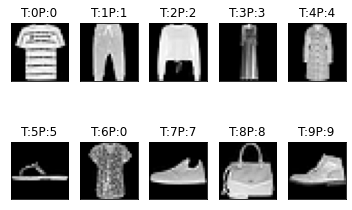

In [ ]:
fig = plt.figure()
for i in range(10):
  plt.subplot(2,5,i+1)
  class_indices = train_dataset.targets == i
  data_class = train_dataset.data[class_indices]
  selected_data = random.choice(data_class)
  plt.imshow(selected_data, cmap='gray')
  prediction = get_prediction(selected_data)
  plt.title('T:'+str(i)+'P:'+str(prediction))
  plt.xticks([])
  plt.yticks([])
fig.show()